In [1]:
from configs.config import get_path
import src.utils.presenter as show
import src.utils.checker as check

import src.utils.gen_jobs as rp_proced

import src.models.cp.lateness as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

import time
import pandas as pd
pd.set_option('display.max_rows', 26)

In [2]:
max_time = 60*60*1  # 1h

## Laden der Produktionsaufträge

In [3]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

In [4]:
file = file_template.format(text= "all_jobs")

df_jobs_all = pd.read_csv(data_path / file)
df_jobs_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2297,1440,395,462
1,Job_001,81,3047,1440,510,1097
2,Job_002,101,3404,1440,568,1396
3,Job_003,142,3950,1440,655,1855
4,Job_004,177,2462,1440,393,629
...,...,...,...,...,...,...
407,Job_407,25679,28813,25920,539,2354
408,Job_408,25759,29231,25920,597,2714
409,Job_409,25773,28913,25920,540,2453
410,Job_410,25881,28178,25920,395,1863


In [5]:
df_jobs_all.loc[df_jobs_all['Arrival'].idxmin(), 'Job']

'Job_000'

In [6]:
file = file_template.format(text= "all_ops")
df_ops_all = pd.read_csv(data_path / file)
df_ops_all

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
4115,Job_411,5,M6,88
4116,Job_411,6,M8,19
4117,Job_411,7,M9,48
4118,Job_411,8,M7,36


## Laden der Initialisierungsdaten vom Tag 1

In [7]:
day_numb = 1

In [8]:
# Waiting Plan
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
df_plan_waiting = pd.read_csv(data_path / file)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,9,M8,81,3047,3017,30,3047,0,0,0
1,Job_002,9,M4,101,3404,3371,33,3404,0,0,0
2,Job_003,3,M4,142,3950,2974,99,3073,-877,0,877
3,Job_003,4,M6,142,3950,3081,9,3090,-860,0,860
4,Job_003,5,M8,142,3950,3110,52,3162,-788,0,788
...,...,...,...,...,...,...,...,...,...,...,...
105,Job_031,5,M1,1424,4390,3081,28,3109,-1281,0,1281
106,Job_031,6,M6,1424,4390,3291,46,3337,-1053,0,1053
107,Job_031,7,M5,1424,4390,3337,46,3383,-1007,0,1007
108,Job_031,8,M7,1424,4390,3723,72,3795,-595,0,595


In [9]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(data_path / file)
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,19.98,1459.98,1459.98
1,Job_000,1,0,M1,1486.00,93.25,1579.25,1579.25
2,Job_000,2,0,M2,1636.00,9.98,1645.98,1645.98
3,Job_000,3,0,M3,1650.80,27.84,1678.64,1678.64
4,Job_000,4,0,M4,1681.00,45.47,1726.47,1726.47
...,...,...,...,...,...,...,...,...
190,Job_030,5,1423,M5,2699.04,15.78,1291.82,2714.82
191,Job_031,0,1424,M0,2323.13,29.33,928.46,2352.46
192,Job_031,1,1424,M2,2360.00,76.09,1012.09,2436.09
193,Job_031,2,1424,M4,2593.44,43.99,1213.43,2637.43


In [10]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_plan_undone = pd.read_csv(data_path / file)
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_021,4,970,M8,2631,48
1,Job_011,7,498,M3,2683,52
2,Job_019,0,808,M1,2766,81
3,Job_022,1,1050,M0,2768,13
4,Job_022,2,1050,M2,2781,61
5,Job_021,5,970,M9,2783,72
6,Job_017,2,625,M3,2804,39
7,Job_011,8,498,M4,2808,90
8,Job_028,6,1391,M6,2823,62
9,Job_017,3,625,M2,2843,74


In [11]:
def print_earliest_job(df_jobs_waiting, info="Info"):
    """
    Gibt den frühesten wartenden Job mit Ankunftszeit und Deadline in einer Zeile formatiert aus.

    Format:
    <Info> frühste: <Jobname>    Arrival: <arrival>    Deadline: <deadline>

    Parameter:
    df_jobs_waiting (pd.DataFrame): DataFrame mit Spalten 'Job', 'Arrival' und 'Deadline'.
    info (str): Informationstext für die Ausgabe.
    """
    if df_jobs_waiting.empty:
        print(f"{info} earliest: Keine wartenden Jobs vorhanden.")
        return

    row = df_jobs_waiting.loc[df_jobs_waiting['Arrival'].idxmin()]
    jobname = row['Job']
    arrival = row['Arrival']
    deadline = row['Deadline']
    print(f"\t{info} earliest {jobname}:\tArrival: {arrival}\tDeadline: {deadline}")


## Rolling Planning ab Tag 2

In [12]:
file_template = "04_devpen_{text}.csv"

In [13]:
first_start = 2
last_planning_start = 10

day_length = 1440

Day 02: [2880, 4320)
	Current earliest Job_032:	Arrival: 1445	Deadline: 3864
	Undone earliest Job_011:	Arrival: 498	Deadline: 3638
	Wating earliest Job_001:	Arrival: 81	Deadline: 3047

Solver-Status         : FEASIBLE
Objective Value       : 505640.00
Best Objective Bound  : 312660.00
Laufzeit              : 3601.98 Sekunden
Deviation terms       : 110


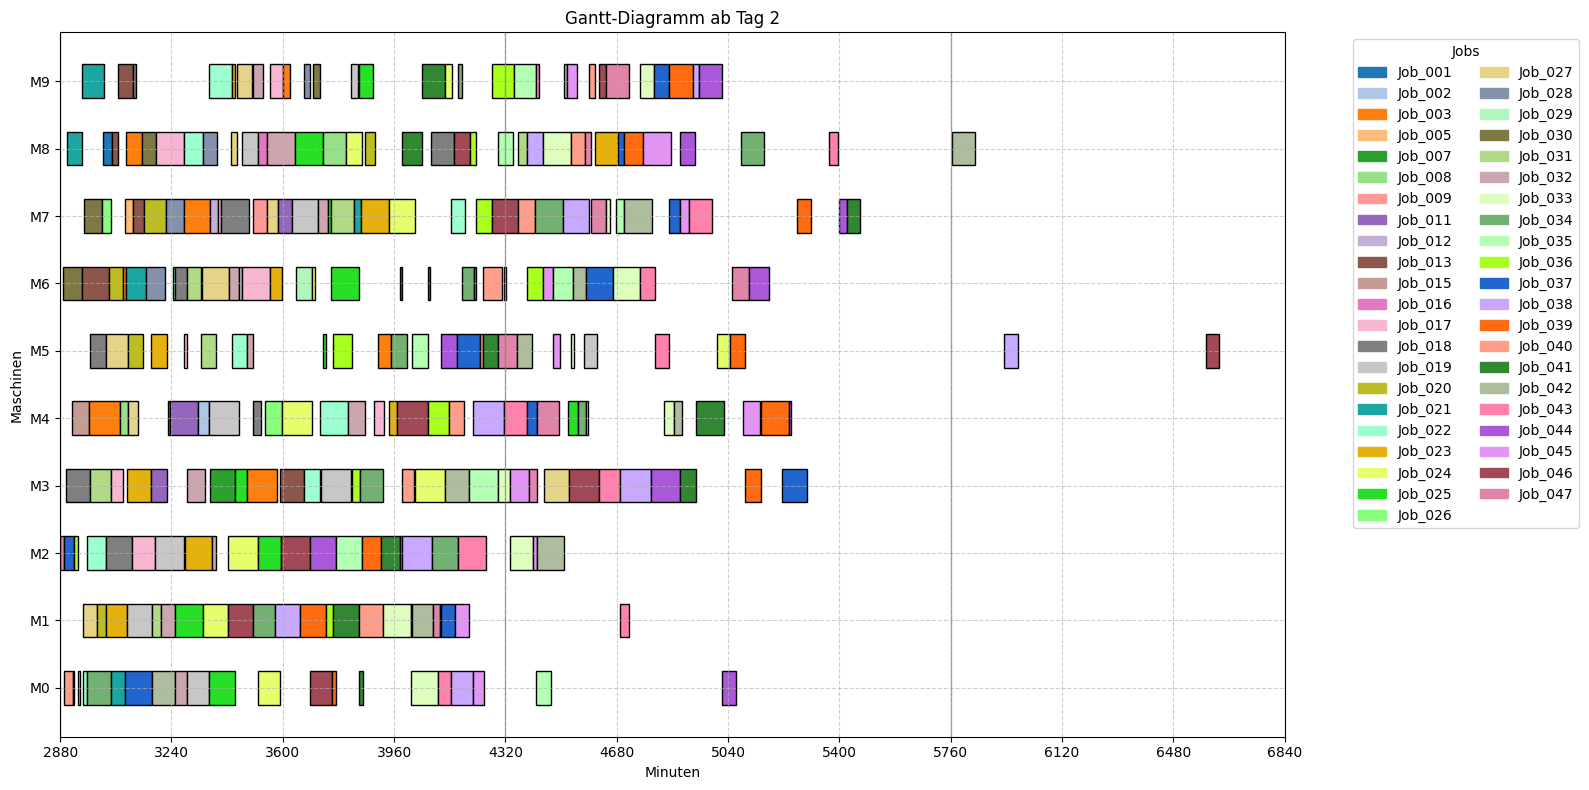

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      1
-60 - 0         7
0              33
0 - 60          2
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 83
[48:00:00] Job_047 started on M2
[48:08:00] Job_030 started on M6
[48:11:00] Job_040 started on M0
[48:12:31] Job_047 finished on M2 (after 12 minutes 32 seconds)
[48:14:00] Job_037 started on M2
[48:20:00] Job_018 started on M3
[48:23:00] Job_021 started on M8
[48:34:06] Job_040 finished on M0 (after 23 minutes 07 seconds)
[48:39:00] Job_015 started on M4
[48:40:00] Job_047 started on M0
[48:46:47] Job_047 finished on M0 (after 06 minutes 47 seconds)
[48:52:05] Job_037 finished on M2 (after 38 minutes 06 seconds)
[48:52:0

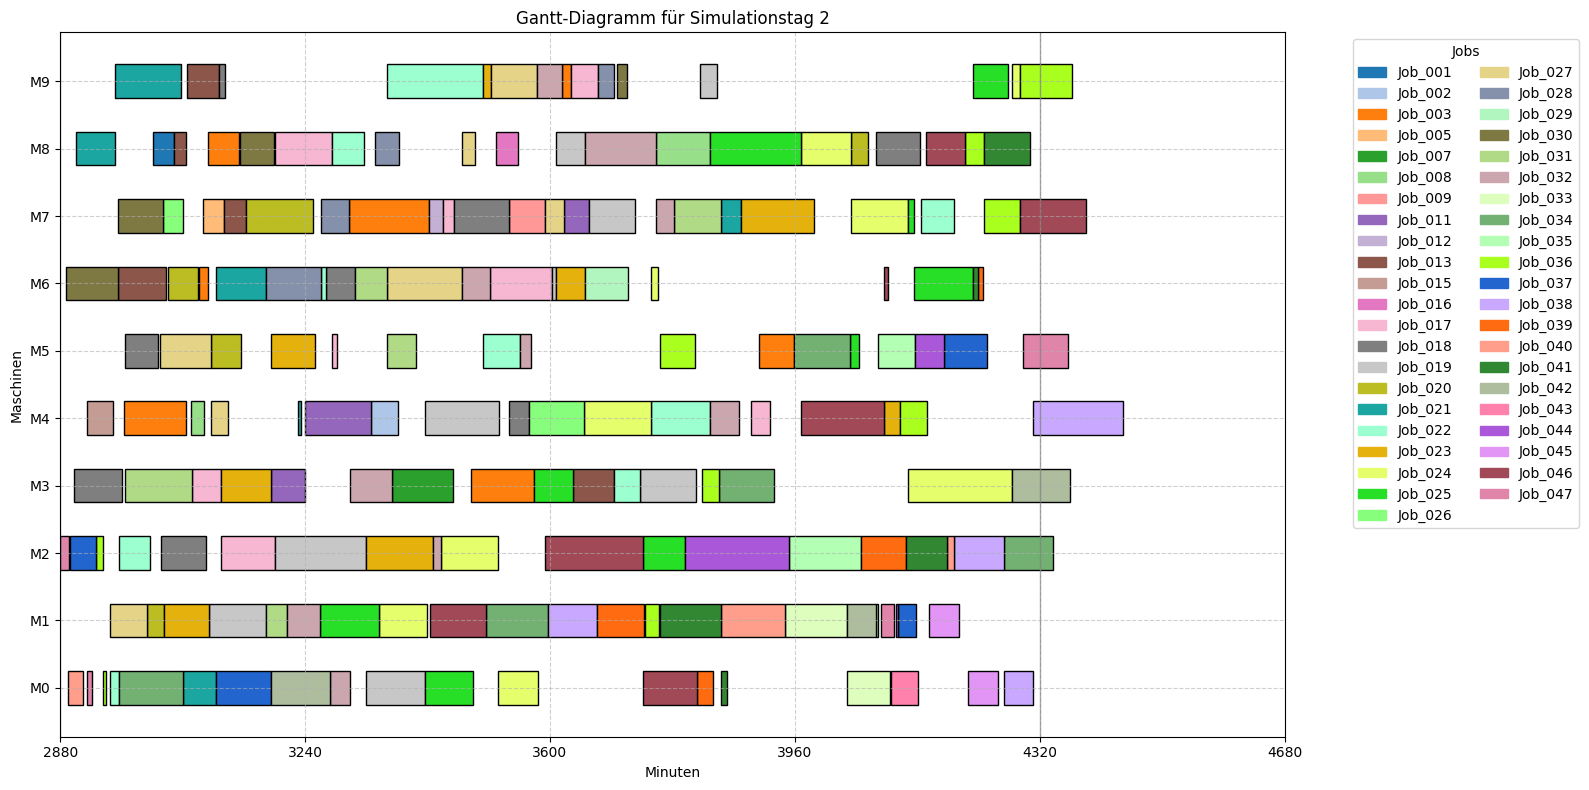

Number of undone operations: 14
_______________________________________________________________________________
Day 03: [4320, 5760)
	Current earliest Job_048:	Arrival: 2930	Deadline: 6064
	Undone earliest Job_033:	Arrival: 1563	Deadline: 4866
	Wating earliest Job_019:	Arrival: 808	Deadline: 4616

Solver-Status         : FEASIBLE
Objective Value       : 599220.00
Best Objective Bound  : 431720.00
Laufzeit              : 3605.94 Sekunden
Deviation terms       : 83


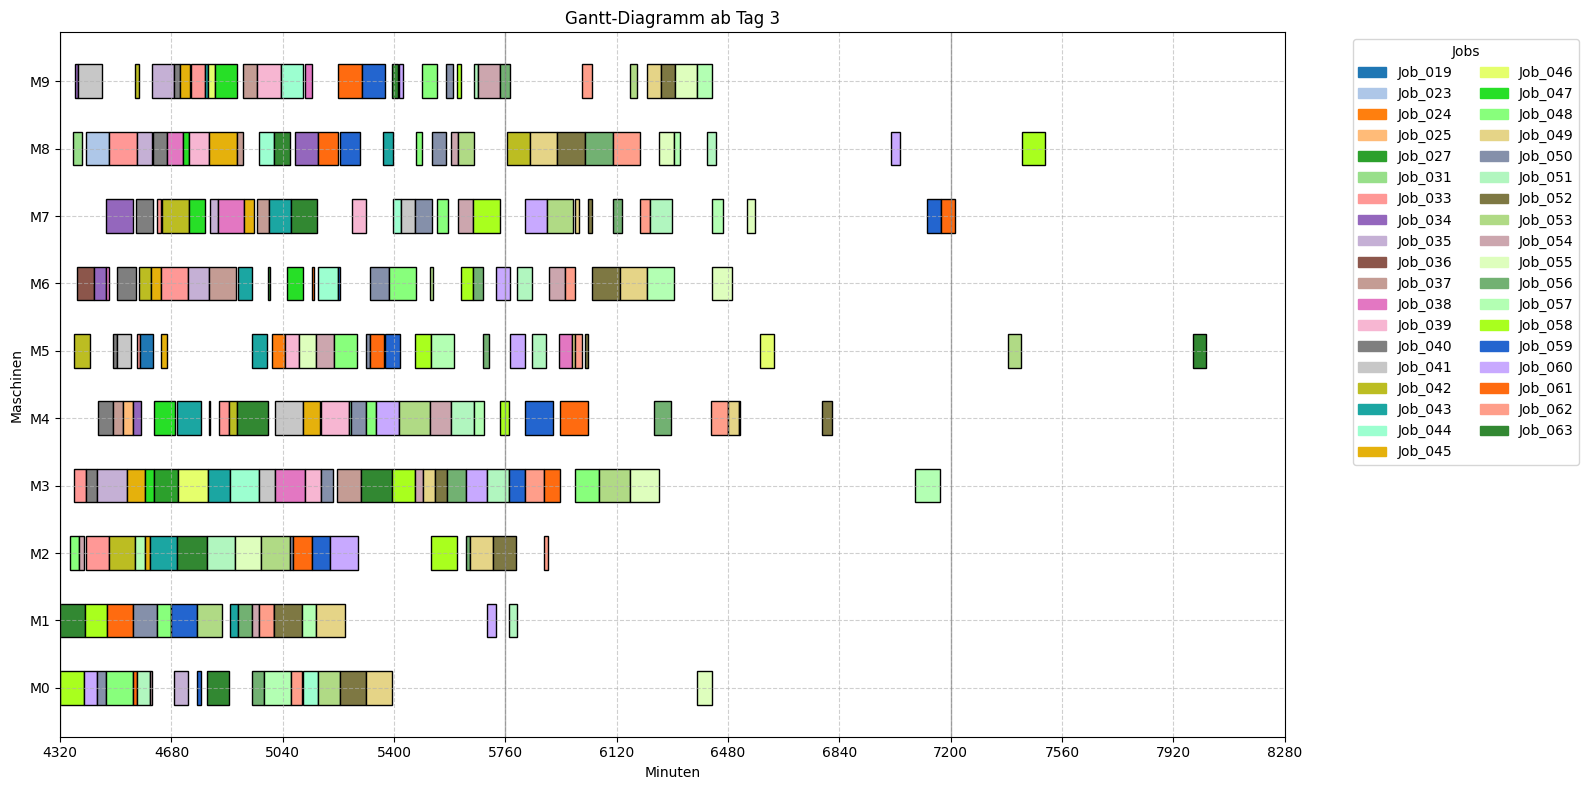

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     1
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              25
0 - 60          4
60 - 120        1
120 - 180       2
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 60
[72:00:00] Job_058 started on M0
[72:00:00] Job_063 started on M1
[72:31:00] Job_048 started on M2
[72:40:00] Job_031 started on M8
[72:45:00] Job_033 started on M3
[72:45:00] Job_042 started on M5
[72:47:00] Job_034 started on M9
[72:55:00] Job_036 started on M6
[73:01:43] Job_048 finished on M2 (after 30 minutes 43 seconds)
[73:02:00] Job_054 started on M2
[73:02:38] Job_034 finished on M9 (after 15 minutes 38 seconds)
[73:02:38] Job_041 started on M9
[73:13:13] Job_063 finished on M1 (after 73 minutes 14 seconds)
[73:16

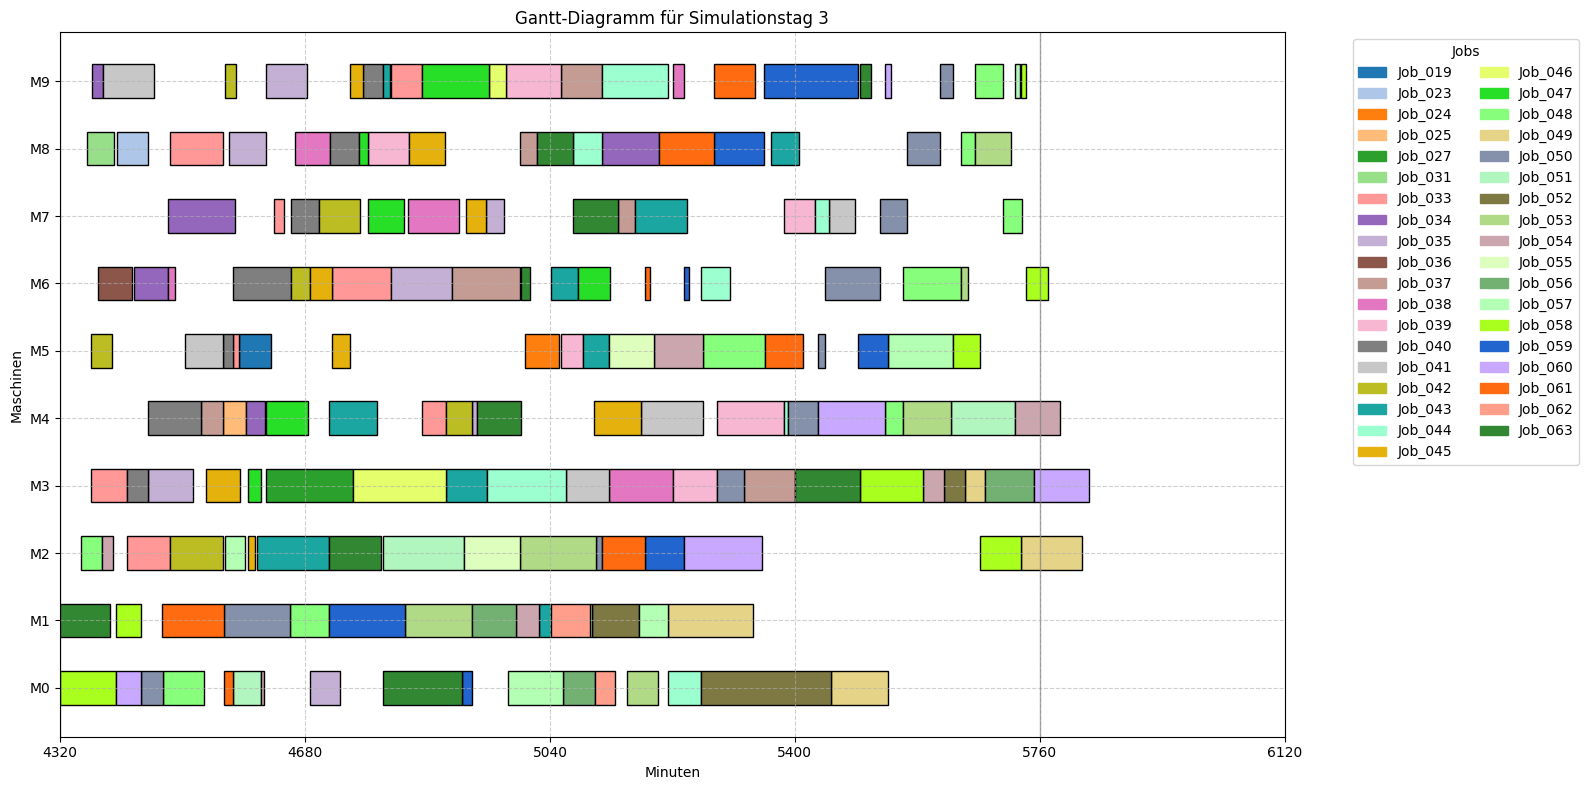

Number of undone operations: 14
_______________________________________________________________________________
Day 04: [5760, 7200)
	Current earliest Job_064:	Arrival: 4352	Deadline: 7655
	Undone earliest Job_051:	Arrival: 3475	Deadline: 6441
	Wating earliest Job_038:	Arrival: 2167	Deadline: 5976

Solver-Status         : FEASIBLE
Objective Value       : 199620.00
Best Objective Bound  : 194160.00
Laufzeit              : 3601.13 Sekunden
Deviation terms       : 60


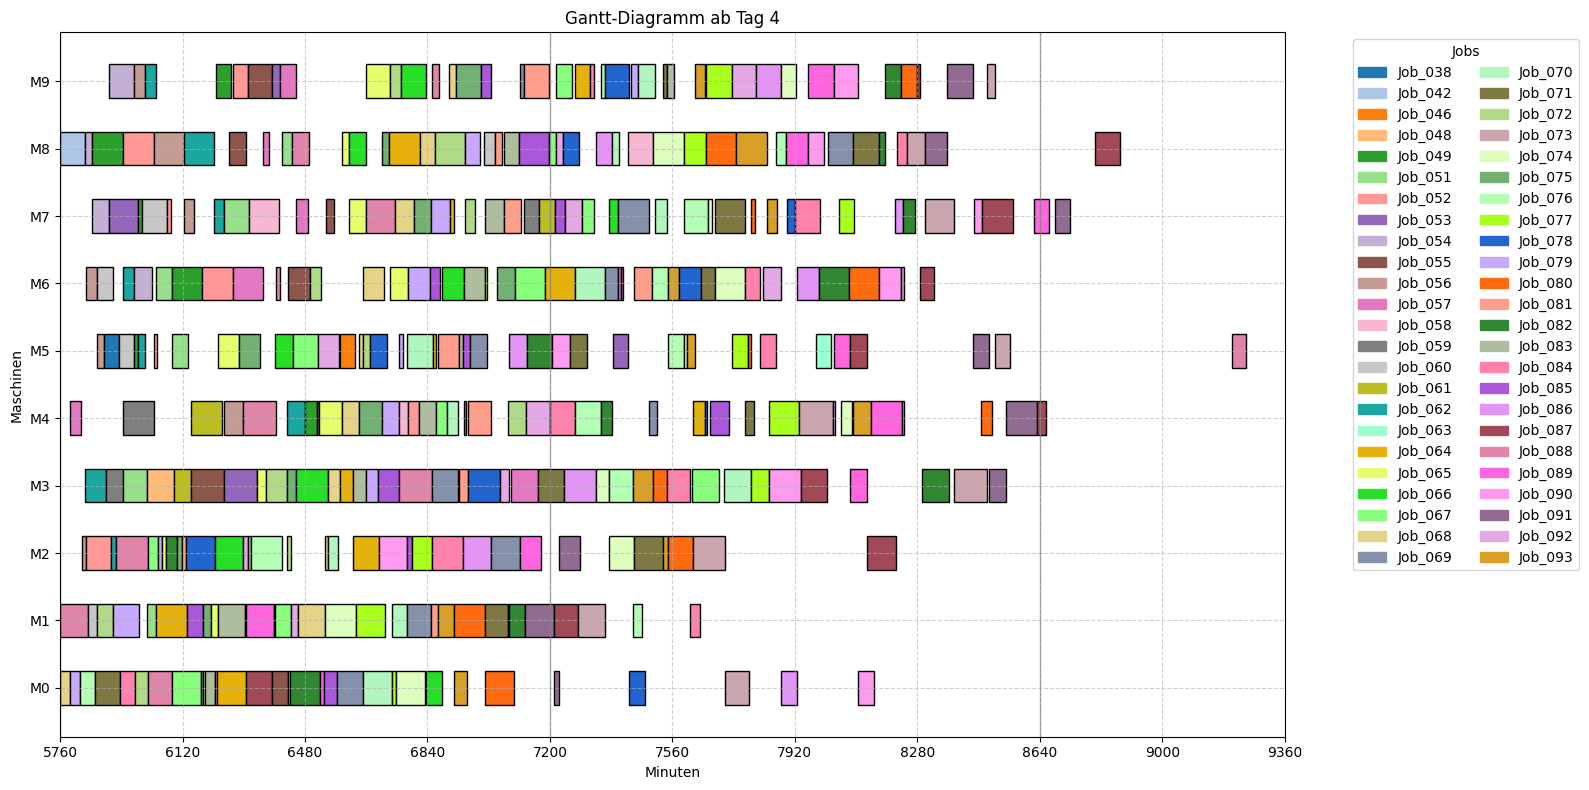

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              40
0 - 60          2
60 - 120        1
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 143
[96:00:00] Job_042 started on M8
[96:00:00] Job_068 started on M0
[96:00:00] Job_088 started on M1
[96:27:41] Job_068 finished on M0 (after 27 minutes 41 seconds)
[96:29:00] Job_079 started on M0
[96:30:00] Job_057 started on M4
[96:51:03] Job_079 finished on M0 (after 22 minutes 04 seconds)
[96:58:00] Job_076 started on M0
[97:00:23] Job_088 finished on M1 (after 60 minutes 23 seconds)
[97:03:00] Job_056 started on M2
[97:07:11] Job_057 finished on M4 (after 37 minutes 12 seconds)
[97:13:00] Job_062 started on M3
[97:14:

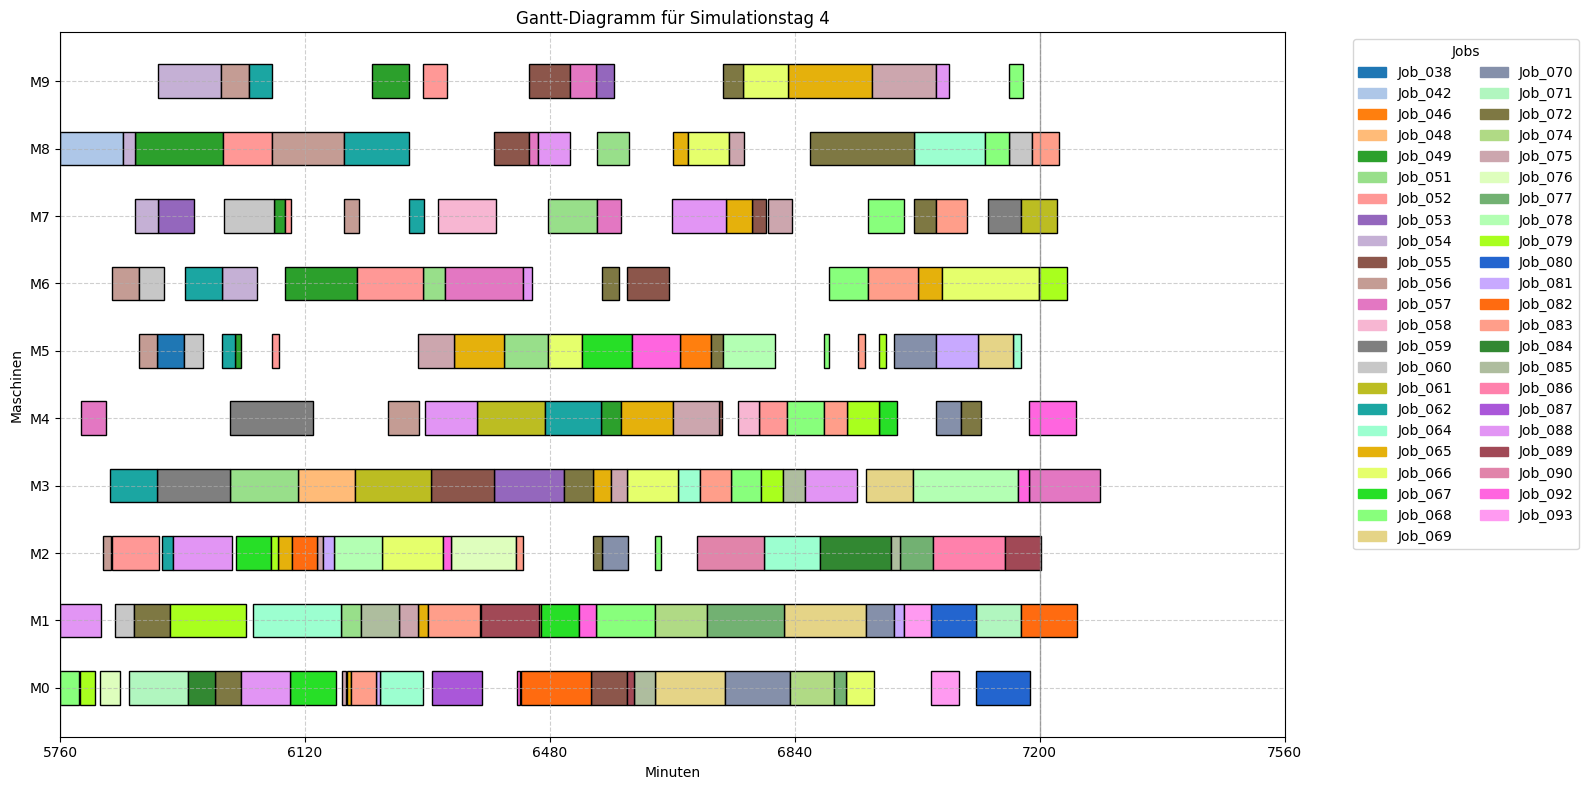

Number of undone operations: 26
_______________________________________________________________________________
Day 05: [7200, 8640)
	Current earliest Job_094:	Arrival: 5804	Deadline: 9108
	Undone earliest Job_064:	Arrival: 4352	Deadline: 7655
	Wating earliest Job_053:	Arrival: 3620	Deadline: 7429

Solver-Status         : FEASIBLE
Objective Value       : 1294300.00
Best Objective Bound  : 797460.00
Laufzeit              : 3600.80 Sekunden
Deviation terms       : 143


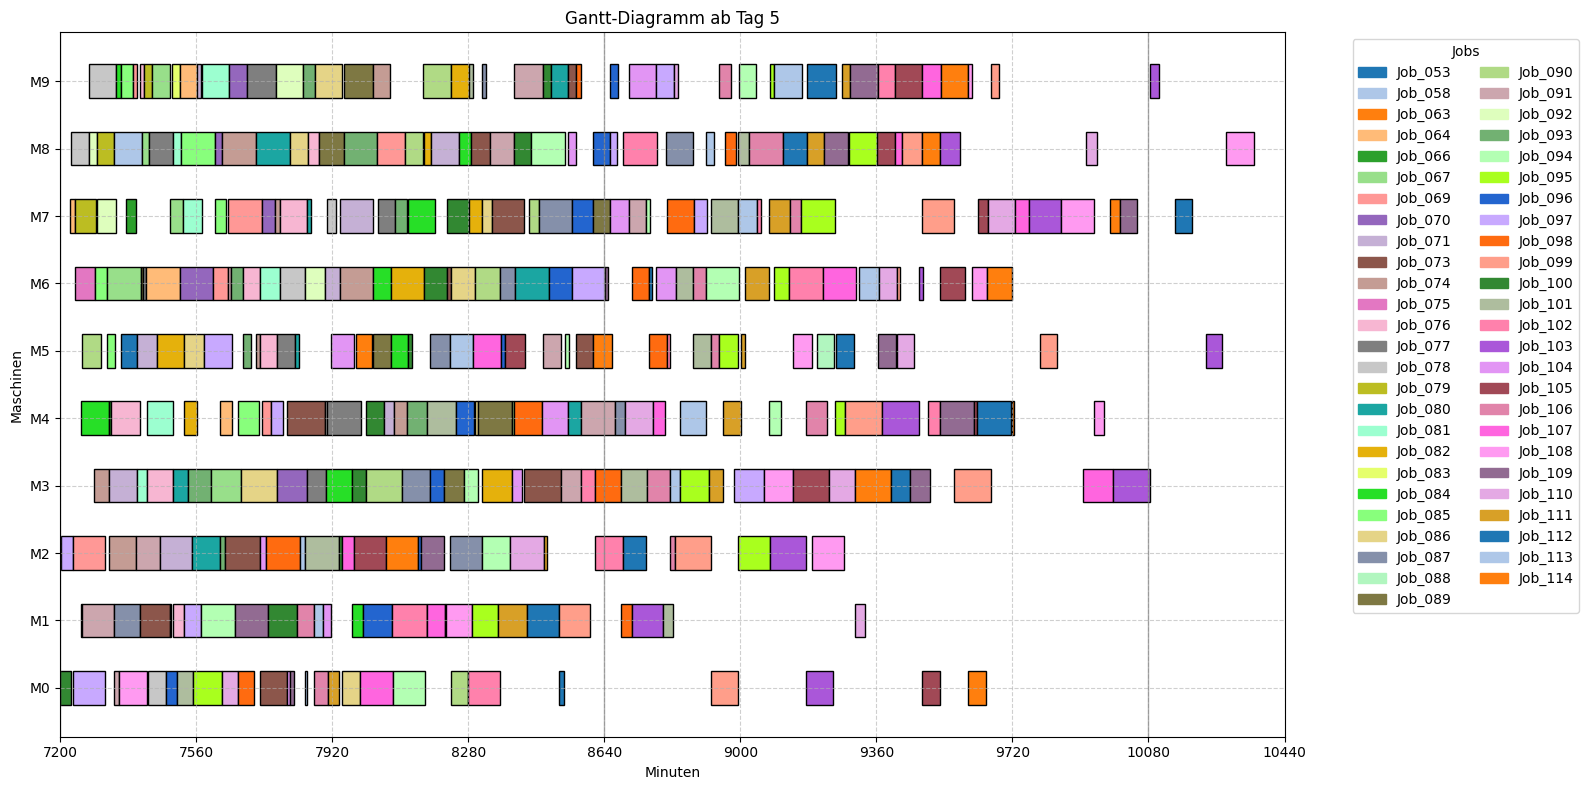

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      1
-60 - 0         9
0              22
0 - 60         11
60 - 120        4
120 - 180       1
180 - 240       1
>240            2
Name: count, dtype: int64
Number of waiting operations: 132
[120:00:00] Job_100 started on M0
[120:02:00] Job_097 started on M2
[120:20:55] Job_097 finished on M2 (after 18 minutes 55 seconds)
[120:27:00] Job_064 started on M7
[120:29:00] Job_078 started on M8
[120:32:03] Job_100 finished on M0 (after 32 minutes 04 seconds)
[120:33:00] Job_069 started on M2
[120:33:00] Job_097 started on M0
[120:38:58] Job_064 finished on M7 (after 11 minutes 59 seconds)
[120:40:00] Job_075 started on M6
[120:40:00] Job_079 started on M7
[120:54:00] Job_084 started on M4
[120:55:00] Job_090 starte

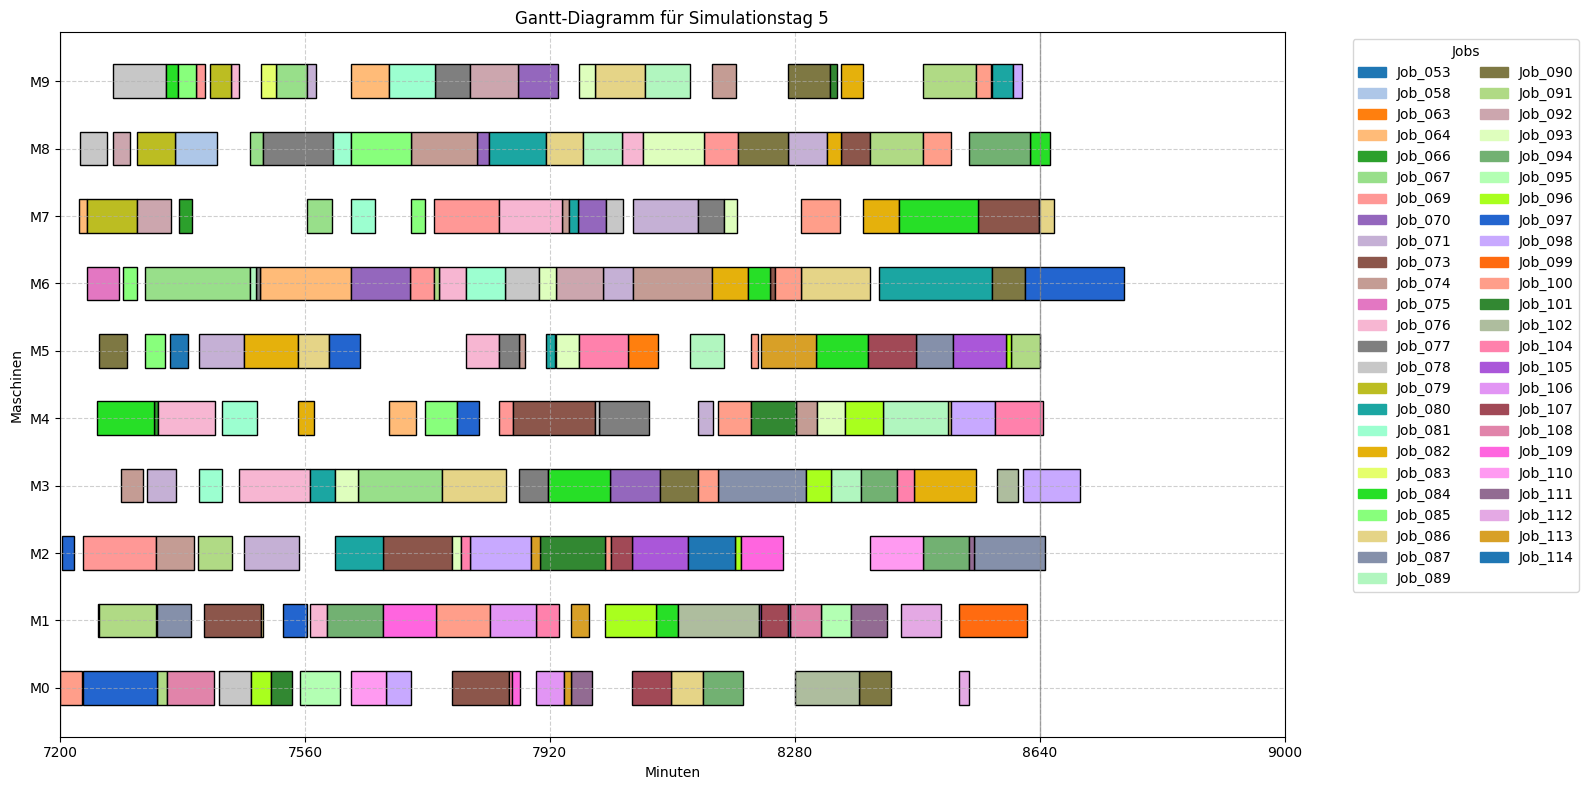

Number of undone operations: 19
_______________________________________________________________________________
Day 06: [8640, 10080)
	Current earliest Job_115:	Arrival: 7224	Deadline: 10696
	Undone earliest Job_073:	Arrival: 4743	Deadline: 8552
	Wating earliest Job_087:	Arrival: 5404	Deadline: 8876

Solver-Status         : FEASIBLE
Objective Value       : 1455380.00
Best Objective Bound  : 1088120.00
Laufzeit              : 3602.97 Sekunden
Deviation terms       : 132


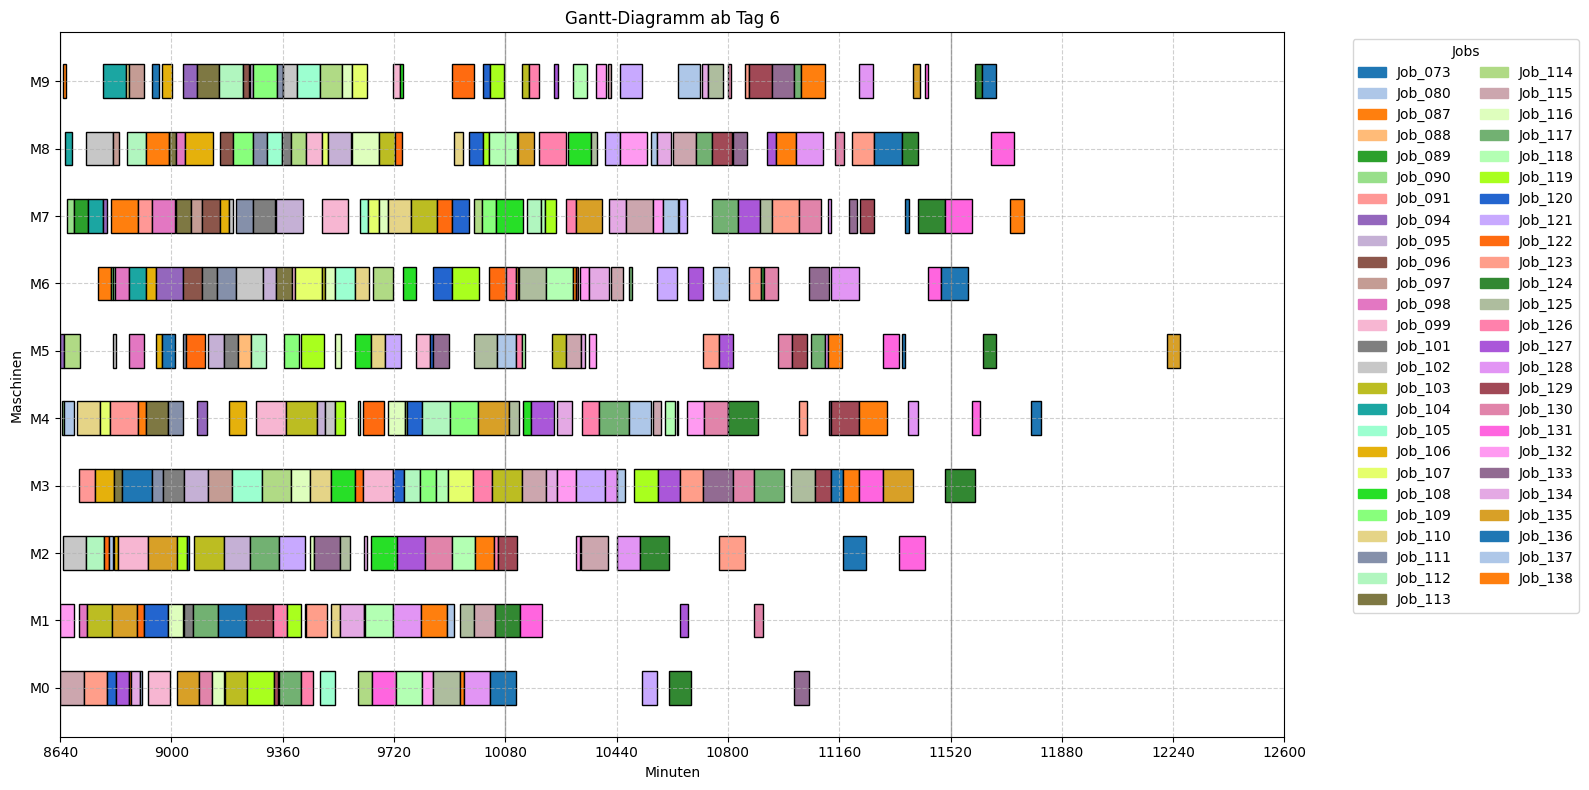

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              28
0 - 60          6
60 - 120        5
120 - 180       1
180 - 240       4
>240            3
Name: count, dtype: int64
Number of waiting operations: 152
[144:00:00] Job_115 started on M0
[144:00:00] Job_132 started on M1
[144:01:00] Job_094 started on M5
[144:06:00] Job_090 started on M4
[144:08:00] Job_087 started on M9
[144:08:00] Job_102 started on M2
[144:12:51] Job_094 finished on M5 (after 11 minutes 51 seconds)
[144:12:51] Job_114 started on M5
[144:13:23] Job_090 finished on M4 (after 07 minutes 23 seconds)
[144:13:23] Job_080 started on M4
[144:16:00] Job_104 started on M8
[144:17:42] Job_087 finished on M9 (after 09 minutes 42 seconds)
[144:21:00] Job_090 starte

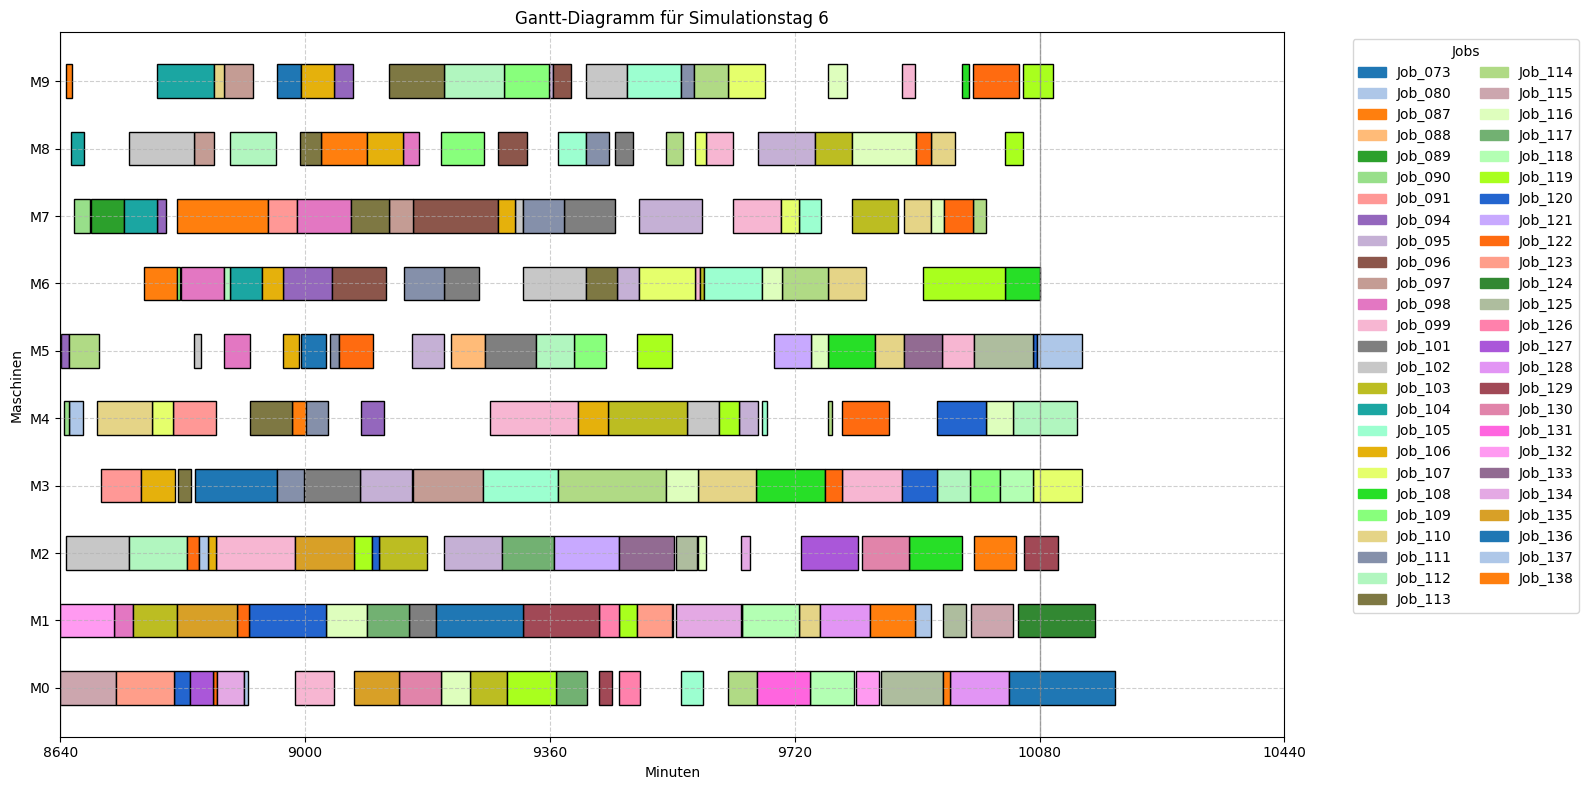

Number of undone operations: 14
_______________________________________________________________________________
Day 07: [10080, 11520)
	Current earliest Job_139:	Arrival: 8644	Deadline: 11778
	Undone earliest Job_103:	Arrival: 6466	Deadline: 10275
	Wating earliest Job_103:	Arrival: 6466	Deadline: 10275

Solver-Status         : FEASIBLE
Objective Value       : 2362380.00
Best Objective Bound  : 1509540.00
Laufzeit              : 3603.11 Sekunden
Deviation terms       : 152


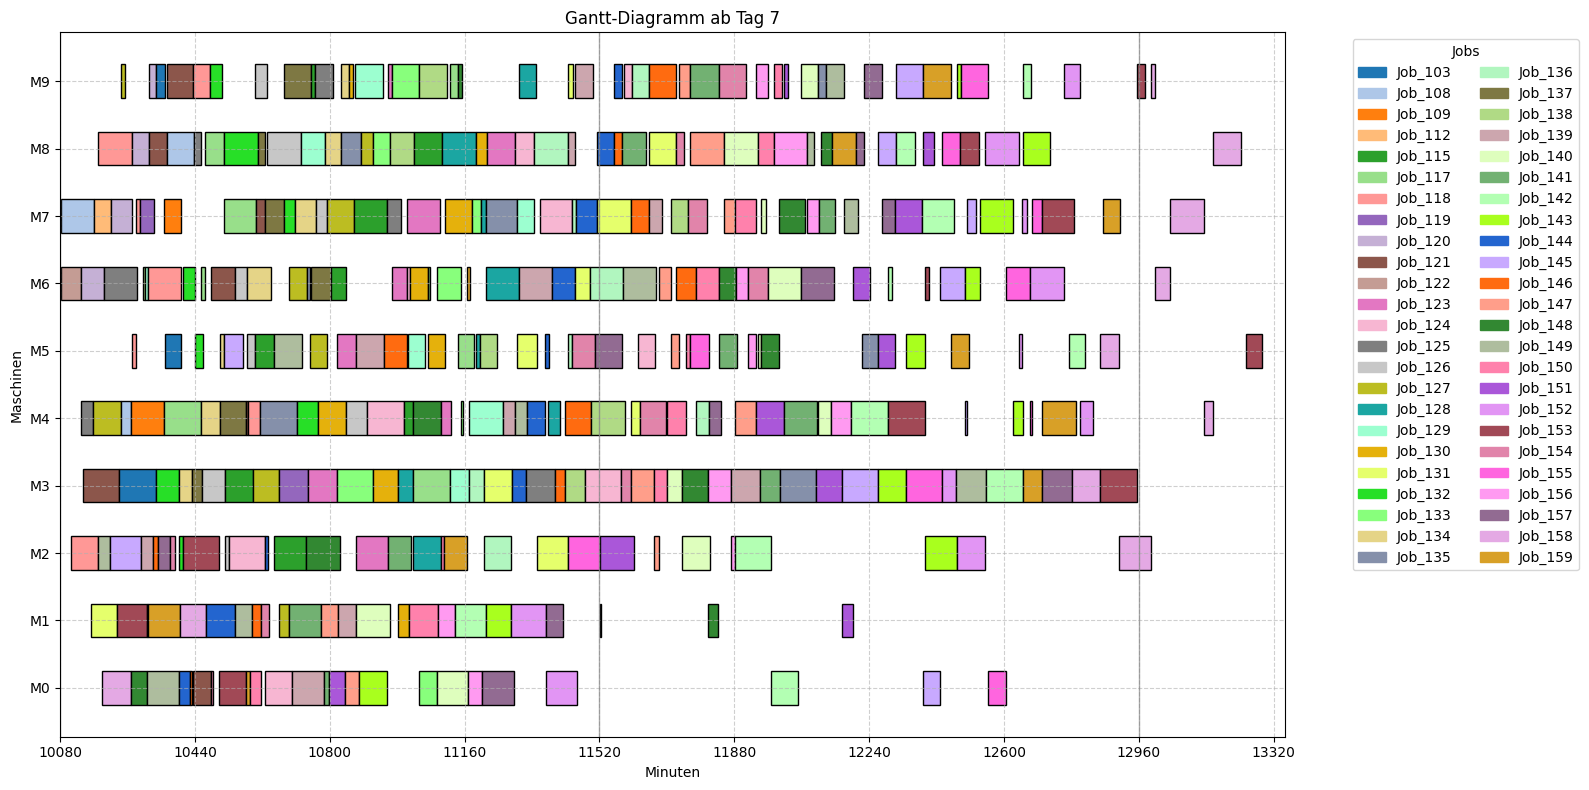

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              12
0 - 60          8
60 - 120        6
120 - 180       4
180 - 240       3
>240           10
Name: count, dtype: int64
Number of waiting operations: 148
[168:02:00] Job_108 started on M7
[168:02:00] Job_122 started on M6
[168:28:00] Job_118 started on M2
[168:52:43] Job_108 finished on M7 (after 50 minutes 44 seconds)
[168:55:00] Job_125 started on M4
[168:56:25] Job_122 finished on M6 (after 54 minutes 26 seconds)
[168:56:25] Job_120 started on M6
[169:02:00] Job_121 started on M3
[169:23:00] Job_131 started on M1
[169:31:00] Job_112 started on M7
[169:33:30] Job_118 finished on M2 (after 65 minutes 30 seconds)
[169:34:28] Job_125 finished on M4 (after 39 minutes 29 seco

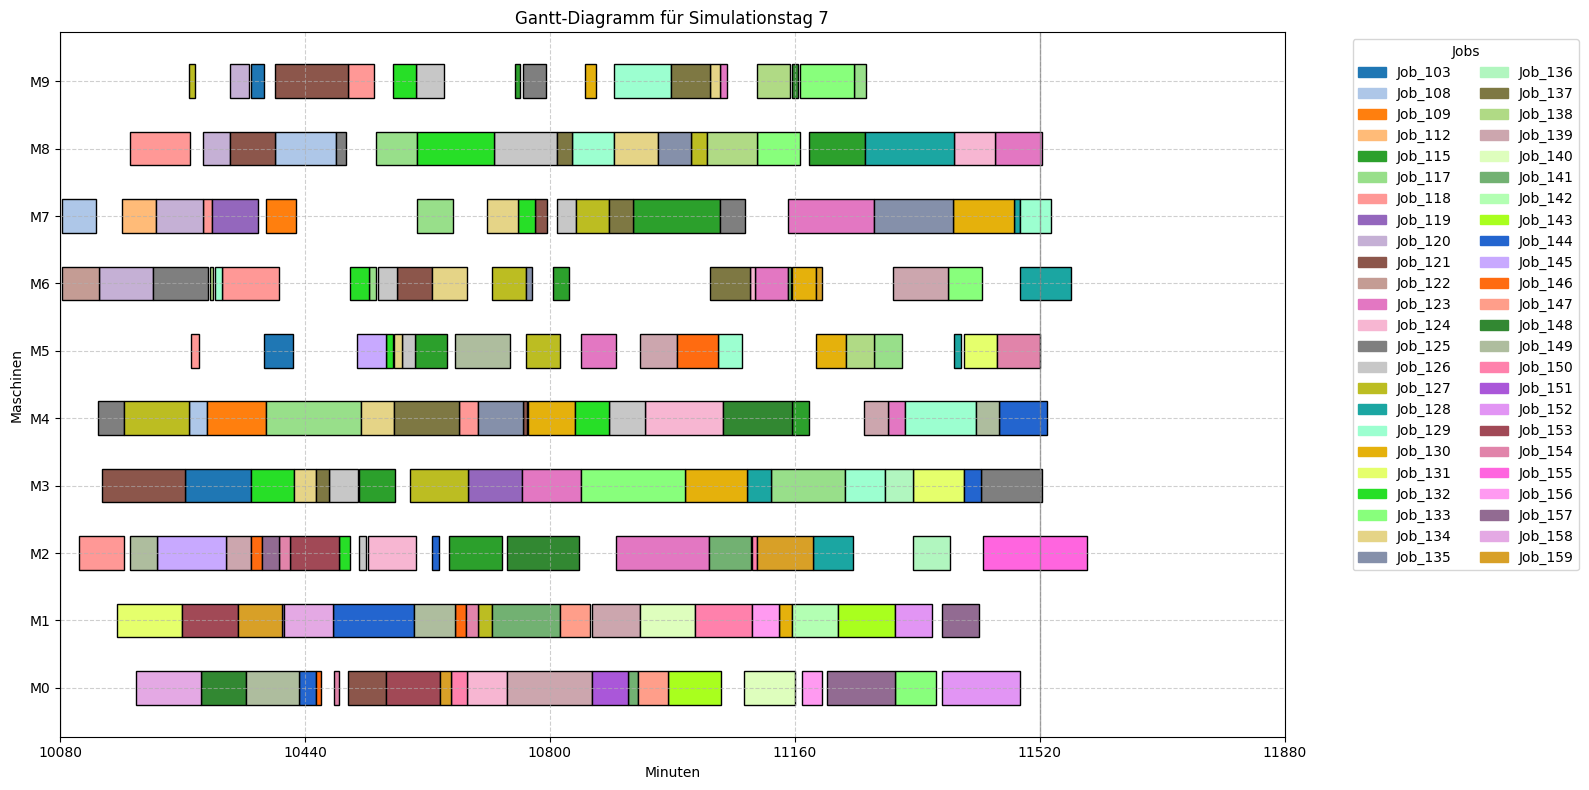

Number of undone operations: 26
_______________________________________________________________________________
Day 08: [11520, 12960)
	Current earliest Job_160:	Arrival: 10092	Deadline: 13227
	Undone earliest Job_124:	Arrival: 7858	Deadline: 11667
	Wating earliest Job_124:	Arrival: 7858	Deadline: 11667

Solver-Status         : FEASIBLE
Objective Value       : 3186560.00
Best Objective Bound  : 2259280.00
Laufzeit              : 3604.63 Sekunden
Deviation terms       : 148


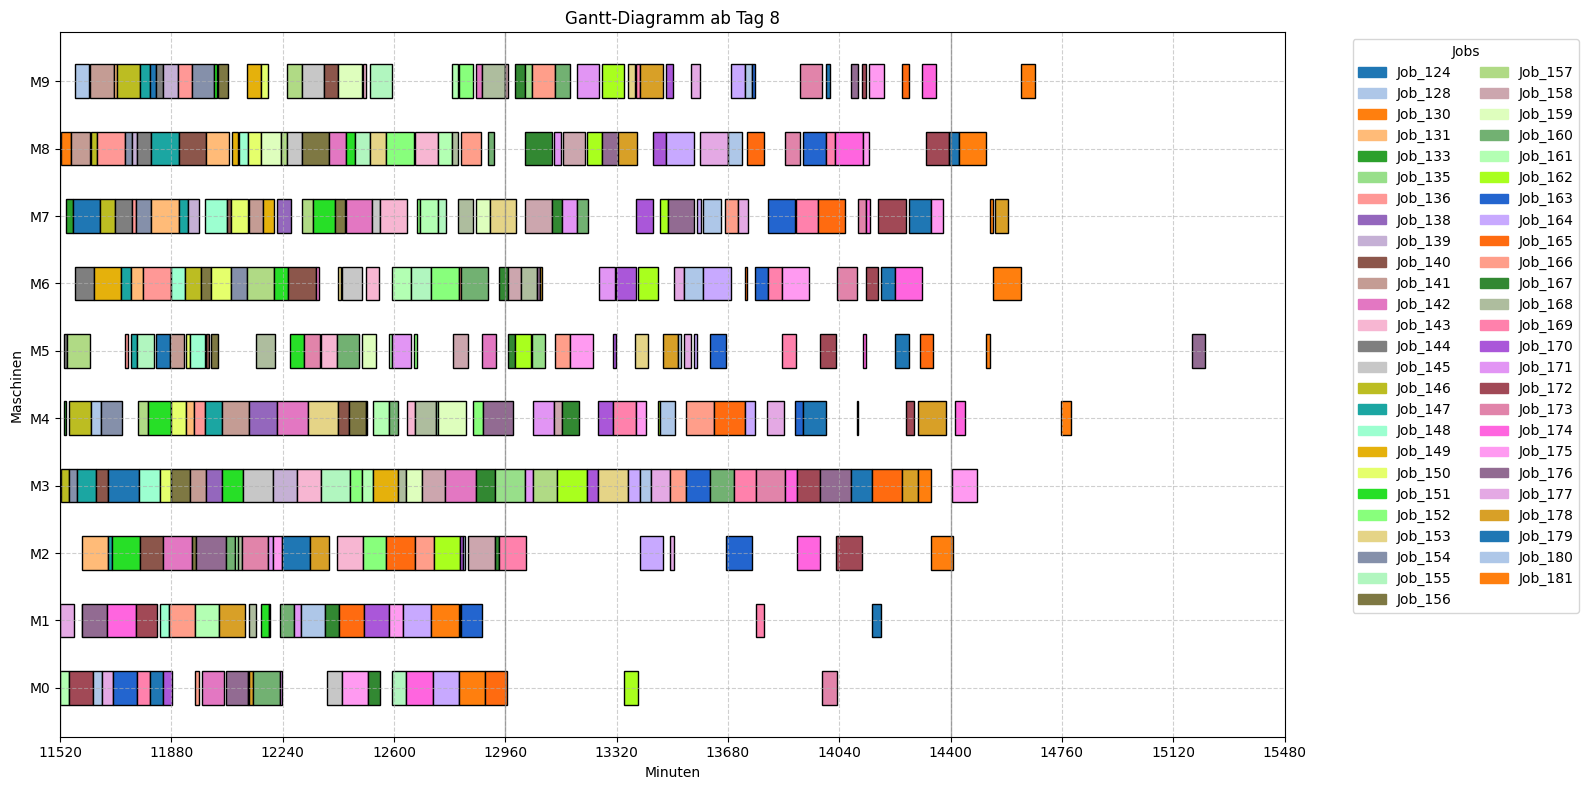

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              11
0 - 60          2
60 - 120        4
120 - 180       4
180 - 240       6
>240           21
Name: count, dtype: int64
Number of waiting operations: 150
[192:00:00] Job_161 started on M0
[192:00:00] Job_177 started on M1
[192:04:00] Job_130 started on M8
[192:04:00] Job_146 started on M3
[192:12:00] Job_133 started on M4
[192:12:00] Job_144 started on M5
[192:19:16] Job_133 finished on M4 (after 07 minutes 16 seconds)
[192:19:16] Job_133 started on M7
[192:22:10] Job_144 finished on M5 (after 10 minutes 11 seconds)
[192:23:00] Job_157 started on M5
[192:24:25] Job_161 finished on M0 (after 24 minutes 26 seconds)
[192:29:00] Job_172 started on M0
[192:29:03] Job_130 finish

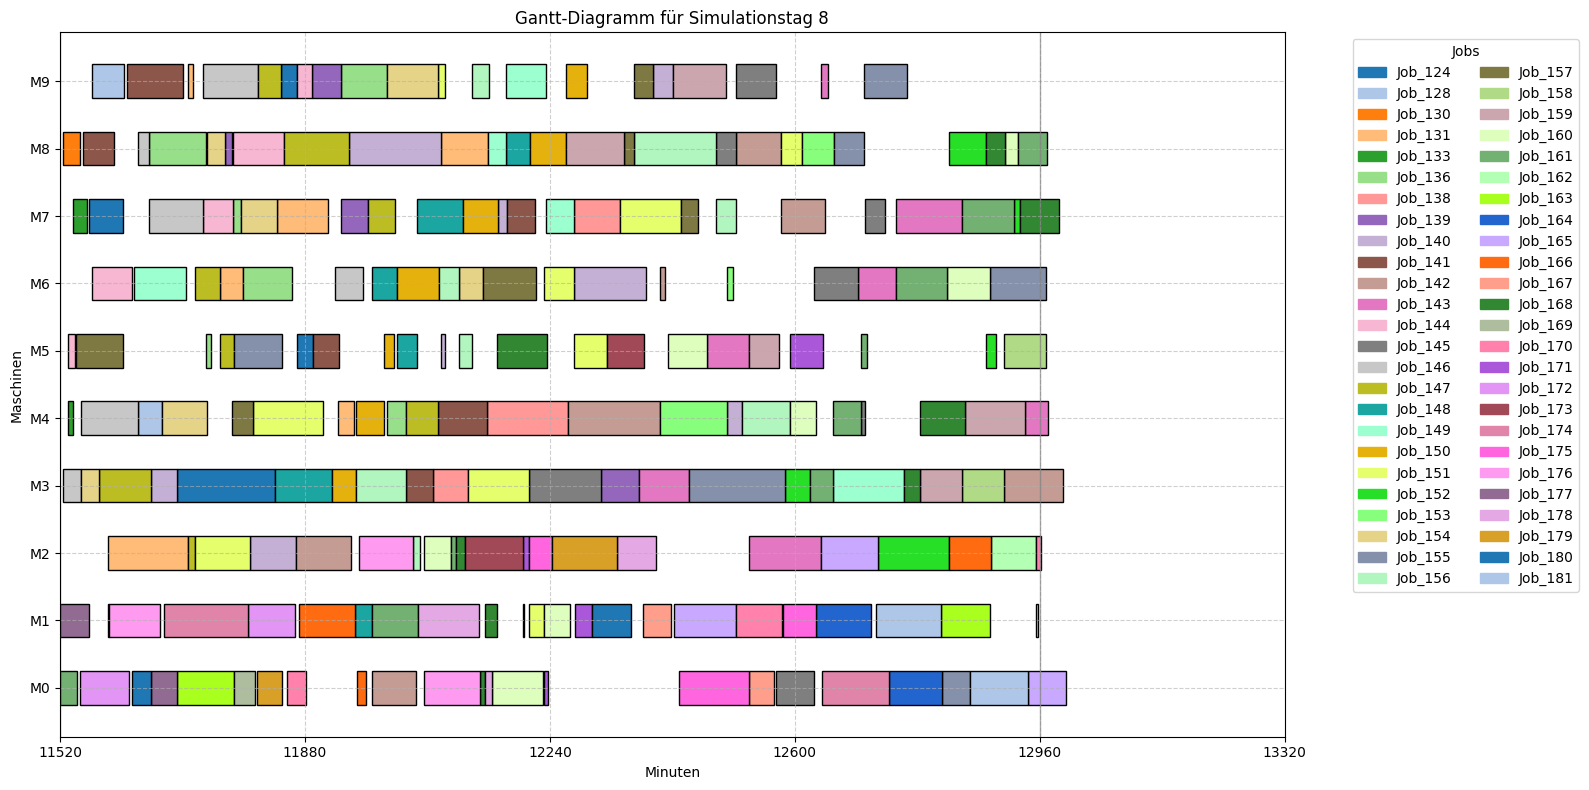

Number of undone operations: 23
_______________________________________________________________________________
Day 09: [12960, 14400)
	Current earliest Job_182:	Arrival: 11613	Deadline: 14498
	Undone earliest Job_135:	Arrival: 8454	Deadline: 12263
	Wating earliest Job_135:	Arrival: 8454	Deadline: 12263

Solver-Status         : FEASIBLE
Objective Value       : 4698400.00
Best Objective Bound  : 3020520.00
Laufzeit              : 3606.95 Sekunden
Deviation terms       : 150


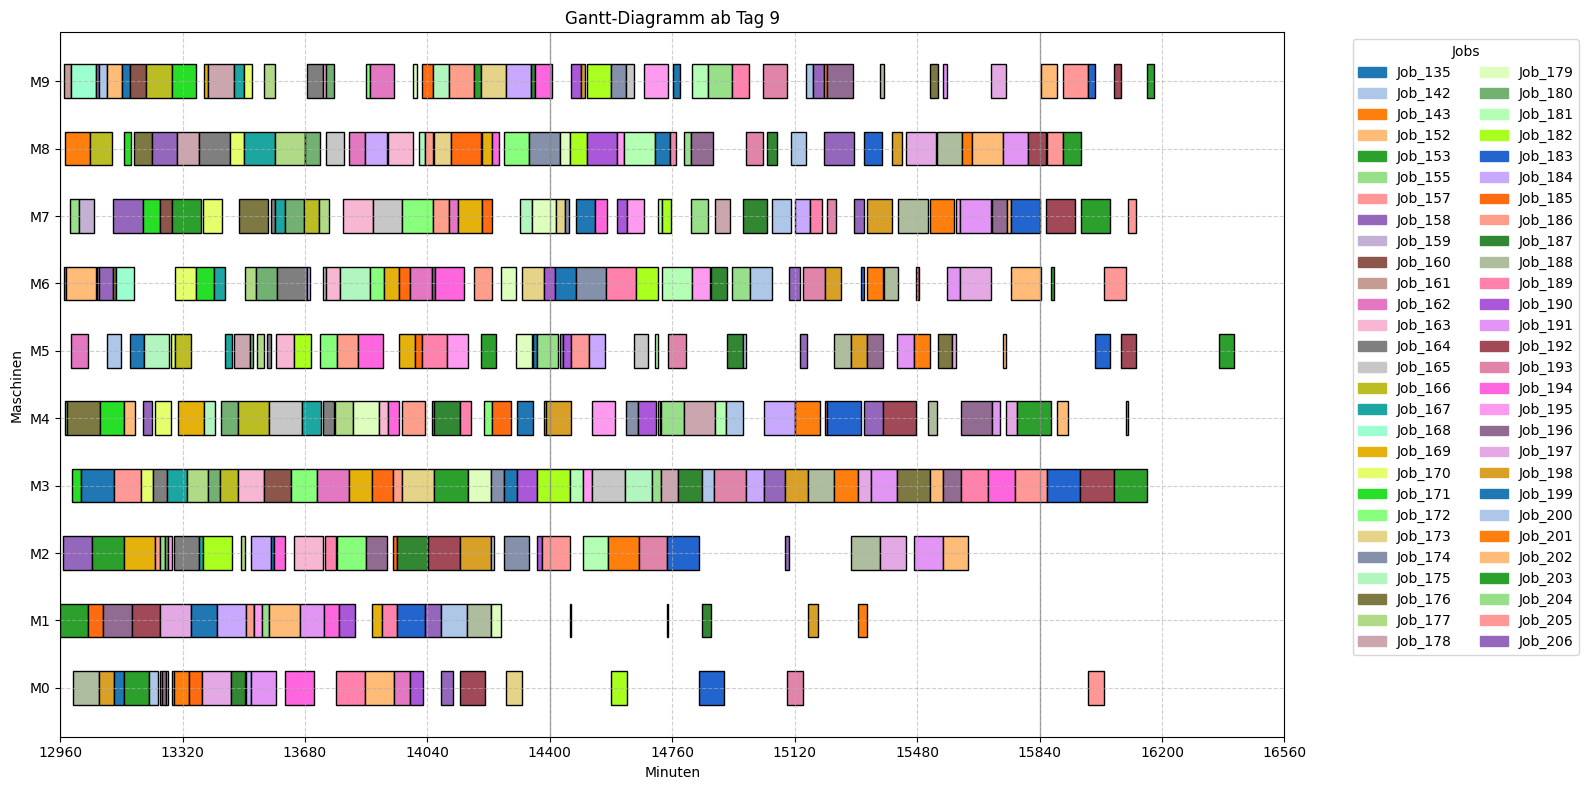

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      1
-60 - 0         2
0               2
0 - 60          7
60 - 120        3
120 - 180       9
180 - 240       7
>240           25
Name: count, dtype: int64
Number of waiting operations: 180
[216:00:00] Job_203 started on M1
[216:09:00] Job_158 started on M2
[216:10:00] Job_166 started on M6
[216:11:00] Job_161 started on M9
[216:13:00] Job_143 started on M8
[216:13:00] Job_155 started on M4
[216:19:16] Job_155 finished on M4 (after 06 minutes 16 seconds)
[216:19:16] Job_176 started on M4
[216:20:38] Job_166 finished on M6 (after 10 minutes 39 seconds)
[216:20:38] Job_152 started on M6
[216:29:15] Job_161 finished on M9 (after 18 minutes 15 seconds)
[216:30:00] Job_155 started on M7
[216:31:00] Job_162 starte

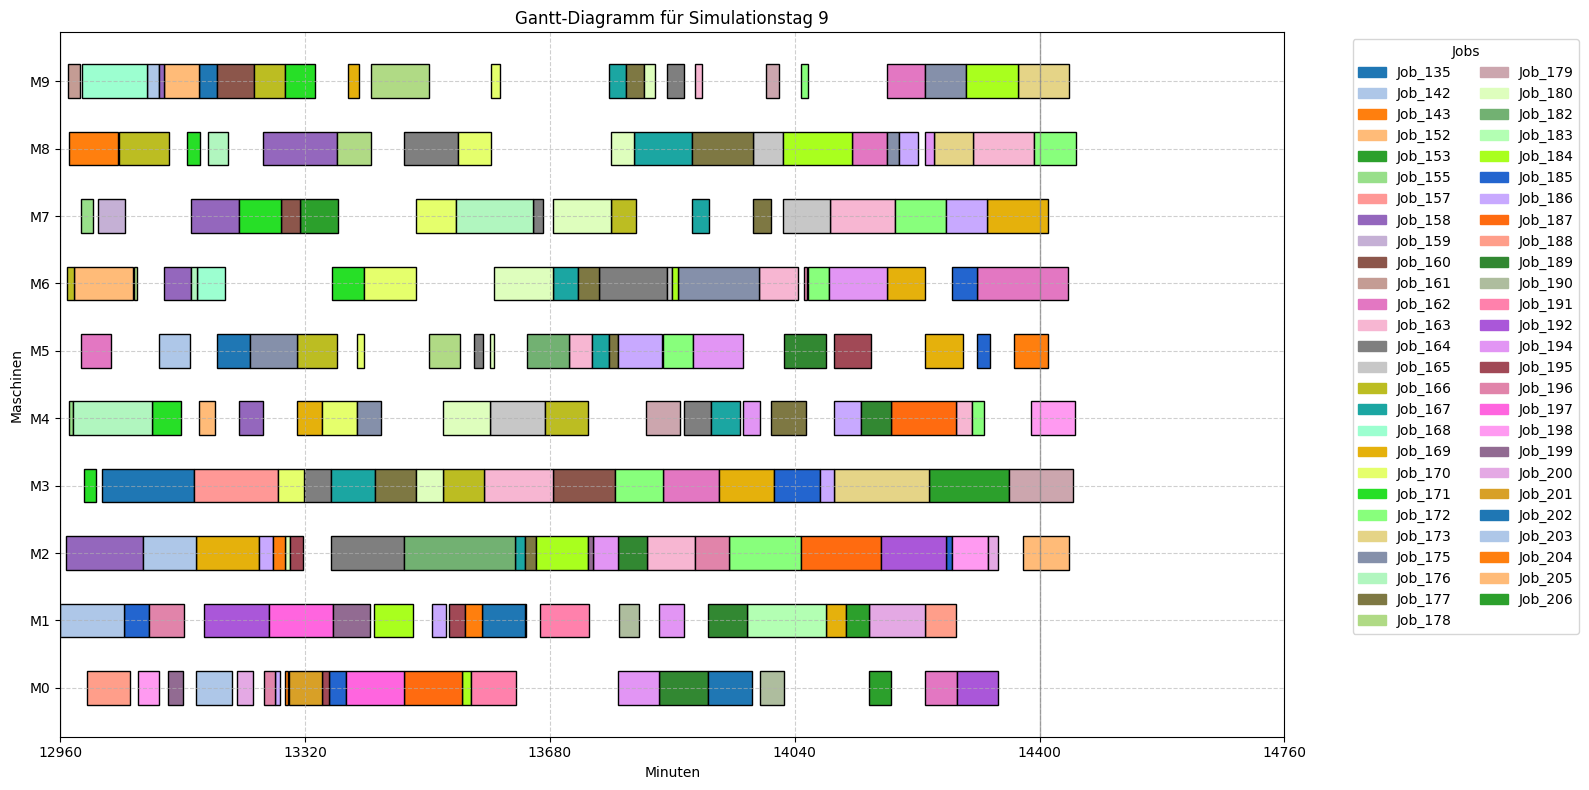

Number of undone operations: 31
_______________________________________________________________________________
Day 10: [14400, 15840)
	Current earliest Job_207:	Arrival: 12982	Deadline: 16117
	Undone earliest Job_153:	Arrival: 9480	Deadline: 13289
	Wating earliest Job_165:	Arrival: 10535	Deadline: 14344

Solver-Status         : FEASIBLE
Objective Value       : 10994700.00
Best Objective Bound  : 7730260.00
Laufzeit              : 3609.52 Sekunden
Deviation terms       : 180


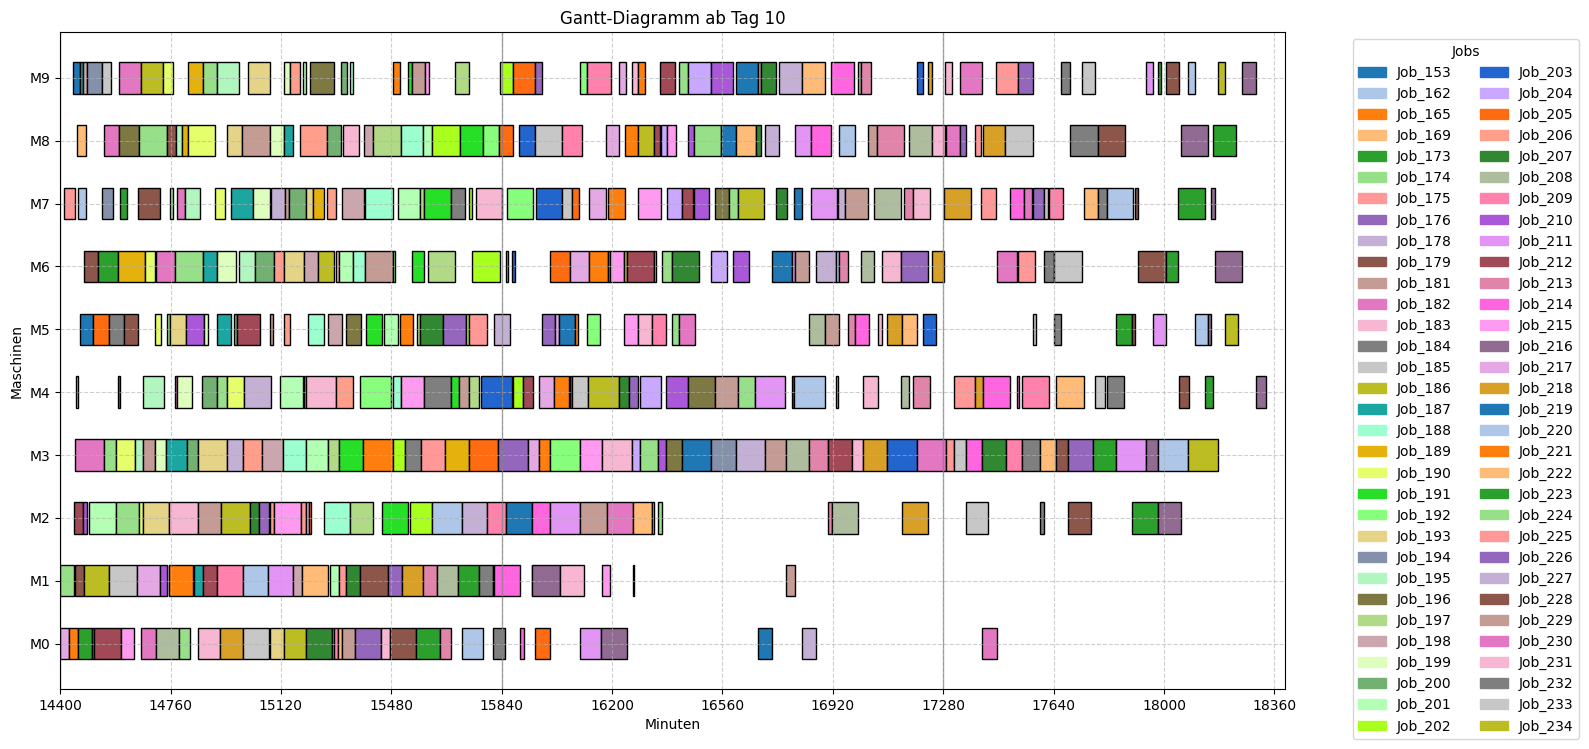

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0               0
0 - 60          5
60 - 120        4
120 - 180       4
180 - 240       0
>240           50
Name: count, dtype: int64
Number of waiting operations: 250
[240:00:00] Job_217 started on M0
[240:00:00] Job_224 started on M1
[240:13:00] Job_175 started on M7
[240:23:21] Job_217 finished on M0 (after 23 minutes 22 seconds)
[240:29:00] Job_221 started on M0
[240:43:00] Job_153 started on M9
[240:43:00] Job_221 finished on M0 (after 14 minutes 01 second)
[240:44:00] Job_212 started on M2
[240:49:00] Job_182 started on M3
[240:52:00] Job_162 started on M4
[240:52:25] Job_175 finished on M7 (after 39 minutes 26 seconds)
[240:54:00] Job_169 started on M8
[240:54:21] Job_224 finishe

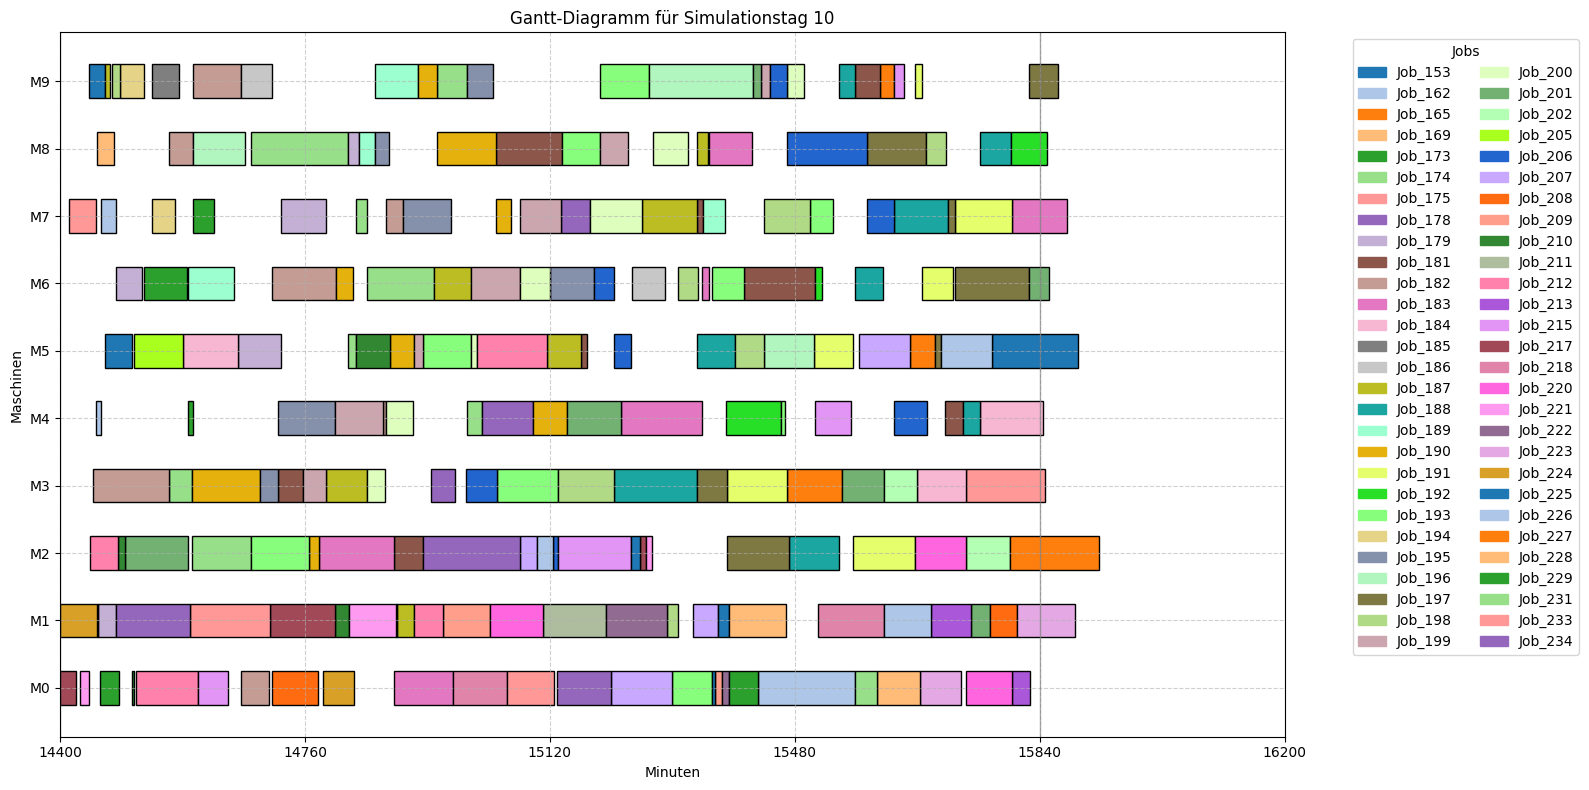

Number of undone operations: 23
_______________________________________________________________________________


In [14]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jobs_curr, df_ops_curr = rp_proced.filter_ops_and_jobs_by_ready_time(df_jobs_all, df_ops_all, ready_time = day_start)
    print_earliest_job(df_jobs_curr, "Current")

    # ---------- b) Unerledigte Operationen ----------------------------

    df_ops_undone = df_ops_all.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_undone = df_jobs_all[df_jobs_all["Job"].isin(df_ops_undone["Job"].unique())]
    print_earliest_job(df_jobs_undone, "Undone")
    
    # ---------- c) Wartende Operationen -------------------------------

    df_ops_waiting = df_ops_all.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_waiting = df_jobs_all[df_jobs_all["Job"].isin(df_plan_waiting["Job"].unique())]
    print_earliest_job(df_jobs_waiting, "Wating")

    # ---------- Zusammenführung ---------------------------------------

    df_ops_curr_combined = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
    df_jobs_curr_combined  = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
    df_jobs_curr_combined = df_jobs_curr_combined.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)

    # ------------------------ Ib. Vorherige Plan ------------------------------- 

    # V1 
    df_plan_prev = df_plan_waiting

    # V2
     # df_plan_prev = pd.concat([df_plan_waiting, df_plan_undone]).sort_values(by=["Job", "Start"]).reset_index(drop=True)
    
    # ------------------------ II. Rescheduling ---------------------------------

    # Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
    df_execution_important = df_execution[df_execution["End"] >= day_start]

    # Rescheduling
    df_plan = solver.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_ops_curr_combined, df_jobs_curr_combined, 
                                                                                 df_execution_important,
                                                                                 df_original_plan = df_plan_prev,
                                                                                 w_t = 5,
                                                                                 r = 0.40, # 40% Lateness, 60% Deviation
                                                                                 reschedule_start = day_start, msg=False, 
                                                                                 timeLimit=max_time, gapRel= 0.01)
    file = file_template.format(text= f"schedule_{day_numb:02d}")
    df_plan.to_csv(data_path / file, index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.is_machine_conflict_free(df_plan)
    check.is_operation_sequence_correct(df_plan)
    check.is_job_timing_correct(df_plan)
    check.is_start_correct(df_plan)
    
    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    
    # ------------------------ III. Aufteilung des Schedules --------------------

    df_plan_for_sim = rp_proced.filter_plan_for_today(df_plan, latest_op_start = day_end)
    
    df_plan_waiting = rp_proced.filter_plan_for_future(df_plan, earliest_op_start = day_end)
    waiting_numb = len(df_plan_waiting)
    print(f"Number of waiting operations: {waiting_numb}")


    # ------------------------ IV. Simulation -----------------------------------

    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.25)
    df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

    undone_numb = len(df_plan_undone)
    print(f"Number of undone operations: {undone_numb}")
    print("_"*79)